In [1]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.coordinates as coord
from astropy.table import Table
from astropy.coordinates.representation import CartesianRepresentation

from astropy.coordinates import ICRS
from astropy.coordinates import Galactic

In [2]:
tab = Table.read('/home/tommaso/Scrivania/Gaia_Sprint_Seattle/GaiaDR2_vrad_vel_small_v.fits')

In [3]:
Av = 4.74047 * u.km * u.yr / u.s

vSun = [14.0, 12.24, 7.25] * u.km / u.s # (U, V, W) Schonrich+12
vrot = [0., 238., 0.] * u.km / u.s # Circular rotation velocity at Sun Position, Bland-hawthorn & Gerhard 2016
#vrot = [0., 250., 0.] * u.km / u.s # Circular rotation velocity at Sun Position, Bland-hawthorn & Gerhard 2016

v_sun = vSun + vrot

dLSR = 8.2 * u.kpc

In [4]:
def get_vtot_hvs(l, b, pi, mu_l, mu_b, vrad, dhvs):
    
    vrad_term = vrad * dhvs - vrad * dLSR * np.cos(b) * np.cos(l)
    mu_l_term = mu_l * Av * dLSR / pi * np.sin(l)
    mu_b_term = mu_b * Av * dLSR / pi * np.sin(b) * np.cos(l)
    
    vsun_term_1 = dhvs * ( np.cos(b)*np.cos(l)*v_sun[0] + np.cos(b)*np.sin(l)*v_sun[1] + np.sin(b)*v_sun[2] )
    vsun_term_2 = - dLSR * np.cos(b) * np.cos(l) * v_sun[0]
    
    vsun_term = vsun_term_1 + vsun_term_2
    
    dGC = np.sqrt(dhvs**2. + dLSR**2. - 2. * dhvs * dLSR * np.cos(b) * np.cos(l) )
    
    return (vrad_term + mu_l_term + mu_b_term + vsun_term )/dGC

In [5]:
source_id = np.array(tab['source_id'], dtype=np.int64)

ra = np.array(tab['ra']) * u.deg
dec = np.array(tab['dec']) * u.deg
pi = np.array(tab['parallax']) * u.mas
e_pi = np.array(tab['e_parallax']) * u.mas
pmra = np.array(tab['pmra']) * u.mas/u.yr
e_pmra = np.array(tab['e_pmra']) * u.mas/u.yr
pmdec = np.array(tab['pmdec']) * u.mas/u.yr
e_pmdec = np.array(tab['e_pmdec']) * u.mas/u.yr
vrad = np.array(tab['vrad']) * u.km/u.s
e_vrad = np.array(tab['e_vrad']) * u.km/u.s

dhvs = np.array(tab['dist']) * u.pc
vtot = np.array(tab['vtot']) * u.km / u.s

### Galactic Coordinates + Galactic Proper Motions:

In [6]:
icrs = coord.ICRS(ra=ra, dec=dec, pm_ra_cosdec=pmra, pm_dec=pmdec, radial_velocity=vrad, distance=dhvs)
gal = icrs.transform_to(Galactic)

In [7]:
l = gal.l.to(u.deg).value * u.deg
b = gal.b.to(u.deg)

pml = gal.pm_l_cosb
pmb = gal.pm_b

In [8]:
pml_app = (pi / Av * (v_sun[0] * np.sin(l) - v_sun[1] * np.cos(l))).to(u.mas/u.yr)
pmb_app = (pi / Av * (v_sun[0] * np.sin(b) * np.cos(l) + v_sun[1] * np.sin(b) * np.sin(l) - v_sun[2] * np.cos(b))).to(u.mas/u.yr)

In [9]:
idxl = np.where(l > 180.*u.deg)

l[idxl] = l[idxl] - 360.*u.deg

### Code Starts!

In [127]:
plt.figure(figsize=(10,6))
plt.scatter(l, b, s = 0.1, alpha=0.005)
plt.xlabel
plt.show()

KeyboardInterrupt: 

In [10]:
vtot_hvs = get_vtot_hvs(l, b, pi, pml, pmb, vrad, dhvs).to(u.km/u.s)

In [11]:
diff_v = np.abs((vtot - vtot_hvs) / vtot_hvs).to(1)

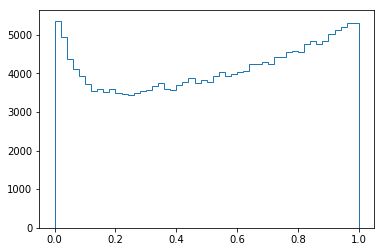

In [12]:
plt.hist(diff_v[diff_v < 1], 50, histtype='step')
plt.show()

In [13]:
threshold = 1.e-2
idx = np.where( (diff_v < threshold) & ( (e_pi / pi).to(1) < 0.15) & (pi > 0))

idx_highv = np.where(vtot[idx].value > 450.)

#threshold = 5.e-3
#idx = np.where( (diff_v < threshold) & ( (e_pi / pi).to(1) < 0.2) & (pi > 0))

print 'There are %i stars with |v - v_hvs| / v_hvs < %s' %(np.size(idx), threshold)
print '%i of these stars have v > 450 km/s' %np.size(idx_highv)

There are 1034 stars with |v - v_hvs| / v_hvs < 0.01
15 of these stars have v > 450 km/s


In [13]:
datalist = [source_id[idx], l[idx], b[idx], pml[idx], e_pmra[idx], pmb[idx], e_pmdec[idx], pi[idx], e_pi[idx], dhvs[idx], vtot[idx], vtot_hvs[idx]]
namelist = ['source_id', 'l', 'b', 'pml', 'e_pml', 'pmb', 'e_pmb', 'varpi', 'e_varpi', 'dist', 'vtot', 'vtot_hvs']

data_table = Table(data=datalist, names=namelist)
data_table.write('/home/tommaso/Scrivania/Gaia_Sprint_Seattle/HVS_radial_trajectory/candidates_v.fits', overwrite=True)


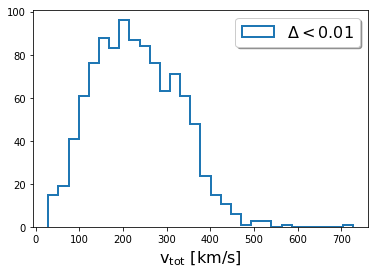

In [14]:
plt.hist(vtot[idx].value, 30, lw=2, histtype='step', label=r'$\mathrm{\Delta < %s}$' %threshold)
plt.xlabel(r'$\mathrm{v_{tot} \ [km/s]}$', fontsize=16)
plt.legend(shadow=True, fancybox=True, fontsize=16)
plt.show()

In [15]:
idx_fast = np.where(vtot[idx] == vtot[idx].max())

ID_fast = source_id[idx][idx_fast]
vtot_fast = vtot[idx][idx_fast]


print 'The fastest star is %s, with a total velocity of %s km/s' %(ID_fast[0], int(np.round(vtot_fast[0].value, 0)))

The fastest star is 4103096400926398592, with a total velocity of 726 km/s


In [16]:
import heapq

idx_fast2 =  np.where(vtot[idx] == heapq.nlargest(2, vtot[idx])[1])

ID_fast2 = source_id[idx][idx_fast2]
vtot_fast2 = vtot[idx][idx_fast2]


print 'The 2nd fastest star is %s, with a total velocity of %s km/s' %(ID_fast2[0], int(np.round(vtot_fast2[0].value, 0)))

The 2nd fastest star is 5808433545428565376, with a total velocity of 568 km/s


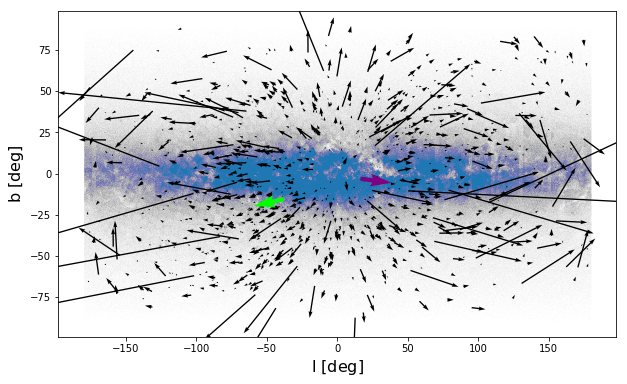

In [17]:
plt.figure(figsize=(10,6))
#plt.title(r'$v_\odot = %s km/s$' %int(vrot[1].value), fontsize=16)
plt.scatter(l, b, s = 0.1, alpha=0.005)
plt.quiver(l[idx], b[idx], pml[idx] - pml_app[idx], pmb[idx] - pmb_app[idx])
plt.quiver(l[idx][idx_fast], b[idx][idx_fast], pml[idx][idx_fast] - pml_app[idx][idx_fast], pmb[idx][idx_fast]- pmb_app[idx][idx_fast], color='purple')
plt.quiver(l[idx][idx_fast2], b[idx][idx_fast2], pml[idx][idx_fast2] - pml_app[idx][idx_fast2], pmb[idx][idx_fast2] - pmb_app[idx][idx_fast2], color='lime')
plt.xlabel(r'$\mathrm{l \ [deg]}$', fontsize=16)
plt.ylabel(r'$\mathrm{b \ [deg]}$', fontsize=16)
plt.savefig('/home/tommaso/Scrivania/Gaia_Sprint_Seattle/HVS_radial_trajectory/candidates_lb.png')
plt.show()

In [ ]:
idx_highv = np.where(vtot[idx].value > 450.)

for i in xrange(np.size(idx_highv)):
    print source_id[idx][idx_highv][i], vtot[idx][idx_highv][i]